# Conteúdo
Este trabalho está dividido em 7 tópicos:

   1. [Desafio](#pblm)
   2. [Bibliotecas e Opções](#pkg)
   3. [Variáveis Quantitativas](#quanti)
   4. [Variáveis Categóricas](#quali)
   5. [Cluster: K-Prototypes](#kproto)
   6. [Futuras Escoragens](#futscr)
   7. [Conclusões Finais](#consfin)

<a id='pblm'></a>
## 1. Desafio

O desafio aqui é encontrar um agrupamento dos usuários que sejá capaz manter a homogeneidade dentro dos grupos e a heterogeneidade fora deles. Foi disponibilizado um dataset contendo 11 variáveis, 7 numéricas e 4 categóricas.

O código desenvolvido foi baseado nas normas do PEP8. 

<a id='pkg'></a>
## 2. Bibliotecas e Opções

Serão utilizados algoritmos já desenvolvidos e testados para a construção dos clusters.  

In [1]:
#===========================
# Visualização e Manipulação
#===========================

import pandas as pd # Manipulação de DataFrames
import matplotlib.pyplot as plt # Visualização de dados
import seaborn as sns # Visualização de dados
import numpy as np # Operações Matemáticas
from mpl_toolkits.mplot3d import Axes3D # Para Plots com 3 dimensões

#===========================
# Visualização e Manipulação
#===========================

from fuzzywuzzy import fuzz # Lógica Fuzzy para encontrar similaridade entre textos
from fuzzywuzzy import process # Lógica Fuzzy para encontrar similaridade entre textos
#https://github.com/seatgeek/fuzzywuzzy

#======================
# Métricas e Algoritmos
#======================

from sklearn.metrics.pairwise import euclidean_distances # Distância Euclidiana
from sklearn.metrics.pairwise import manhattan_distances # Distância de Manhattan

import datetime # Manipulação de datas

from itertools import combinations # Criação de Combinações

from sklearn.cluster import KMeans # Algoritmo K-médias
from kmodes.kmodes import KModes # Algoritmo K-Modas
from kmodes.kprototypes import KPrototypes # Algoritmo K-Prototypes

#=======
# Opções
#=======

sns.set_style('whitegrid') # Estilo dos gráficos do pacote Seaborn
sns.set_context('notebook') # Contexto dos gráficos do pacote Seaborn
np.random.seed(42) # Semente Aleatória para reprodução

%matplotlib inline 
# Magic Function para plotar gráficos

C:\Users\filip\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


<a id='quanti'></a>
## Variáveis Quantitativas

Neste passo, vamos conhecer os dados quantitativos do dataset.

In [2]:
df_path = ".\\Dataset - Code Challenge Data Scientist.xlsx" 
# Diretório
df_orig = pd.read_excel(df_path, sheet_name="Dados") # Import dos dados

# Cria-se uma cópia para preservar o dataset original
df = df_orig.copy()

print("O dataset possui", '{0:,}'.format(df.shape[0]), 
      "linhas e",df.shape[1],"colunas.")
print("\nCabeçalho dos dados:")

df.head() # Cabeçalho

O dataset possui 4,972 linhas e 11 colunas.

Cabeçalho dos dados:


,ID,GEO_REFERENCIA,DATA_NASCIMENTO,PROFISSAO,GENERO,ESTADO_CIVIL,VALOR_01,VALOR_02,VALOR_03,VALOR_04,PERFIL
0,1,780,1992-08-15,ANALISTA DE SISTEMAS,M,SOLTEIRO(A),342.857143,342.857143,428.571429,28.571429,A
1,2,35,1990-02-24,SERVIDOR PÚBLICO ESTADUAL,F,SOLTEIRO(A),942.857143,0.000000,0.000000,0.000000,A
2,3,54,1987-07-17,ANALISTA DE SISTEMAS,M,SOLTEIRO(A),2000.000000,0.000000,0.000000,2857.142857,A
3,4,35,1988-04-27,BANCARIO E ECONOMIÁRIO,M,CASADO(A) COM BRASILEIRO(A) NATO(A),857.142857,285.714286,0.000000,1428.571429,A
4,5,883,1971-12-10,SERVIDOR PÚBLICO MUNICIPAL,M,CASADO(A) COM BRASILEIRO(A) NATO(A),8615.385714,0.000000,0.000000,47471.788571,A


Para se obter uma interpretação mais direta, devemos transformar a data de nascimento em uma idade. Seria ideal que o dataset possuísse uma coluna indicando a data de extração dos dados em questão, pois só assim a idade calculada corresponderia com a realidade. Porém, matemáticamente não existe problema pois a distribuição se mantém (deslocando a média) independente da data de referência adotada.  

In [3]:
def AgeCalc(dt):
    """
    Calcula idade no momento atual
    """
    t = datetime.datetime.now() - dt
    age = t//np.timedelta64(1,'Y')
    return age

# Aplicando a função criada para calcular a idade e 
# construir uma coluna no dataset

df["IDADE"] = df.DATA_NASCIMENTO.apply(AgeCalc)

# Também, removemos a variável Data de Nascimento
# pois não será mais necessária.

df.drop('DATA_NASCIMENTO', axis=1, inplace=True)

Quanto a variável Geo Referência, não consegui identificar qual código ela faz referência e por conta disto, não será utilizada para a construção dos clusters até que seja possível avaliar concretamente o significado de cada um dos códigos.

Com isso, ficamos com 5 variáveis numéricas para compor os clusters. Agora, vamos analisar a distribuição destas variáveis numéricas.

### Análise Descritiva

In [4]:
# Retiramos também o campo 'GEO_REFERENCIA'
df.drop('GEO_REFERENCIA', axis=1, inplace=True)

# e construimos uma tabela sumarizada das variáveis
# numéricas
df.describe().iloc[:,1:]

,VALOR_01,VALOR_02,VALOR_03,VALOR_04,IDADE
count,4972.000000,4.972000e+03,4.972000e+03,4972.000000,4972.000000
mean,2022.698192,1.863806e+04,4.246265e+03,5041.123332,36.865044
std,6098.823138,8.918084e+04,3.764594e+04,23246.036503,10.794923
min,0.000000,0.000000e+00,0.000000e+00,0.000000,2.000000
25%,628.571429,0.000000e+00,0.000000e+00,0.000000,30.000000
50%,1371.428571,0.000000e+00,0.000000e+00,0.000000,35.000000
75%,2571.428571,6.005771e+03,0.000000e+00,1428.571429,41.000000
max,400000.000000,2.857143e+06,1.428571e+06,685714.285714,93.000000


Nota-se que existe uma concentração grande nas variáveis dos valores 2 até 4. A maioria dos usuários possuem valores zerados para estas colunas. Com isso, podemos esperar que um ou mais clusters serão muito maior que os demais.

Também, é possível notar a presença de outliers, que na matriz de gráficos desenhada abaixo ficam mais aparentes.

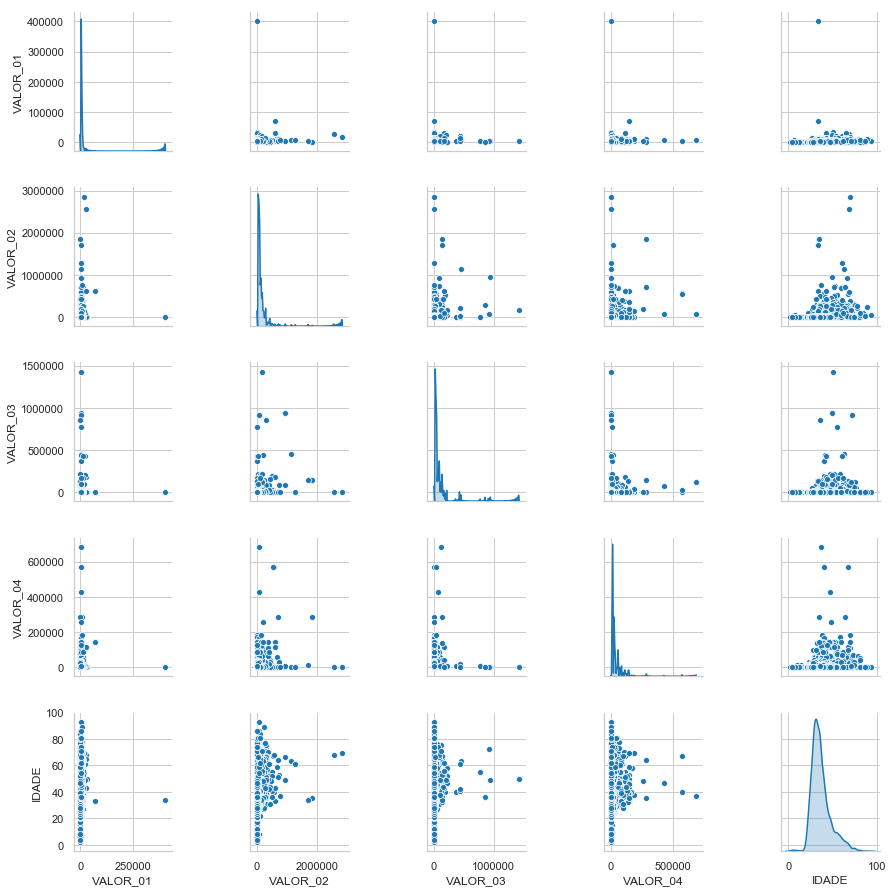

In [5]:
# Separamos as variáveis numéricas
NumVars = 'VALOR_01 VALOR_02 VALOR_03 VALOR_04 IDADE'.split()

# e utilizamos o Seaborn para criar uma matriz de gráficos
# de disperção e das densidades
sns.pairplot(df, vars=NumVars,diag_kind='kde')
plt.tight_layout()
plt.show()

Como esperado, os pontos de distribuem nas bases dos eixos na maioria dos casos. A única barra visível nos histogramas das variáveis de valor indicam um cenário atípico e uma presença forte de outliers.

Para melhor visualizar os outliers, nos apoiamos na visualização de boxplots de cada uma das variáveis.

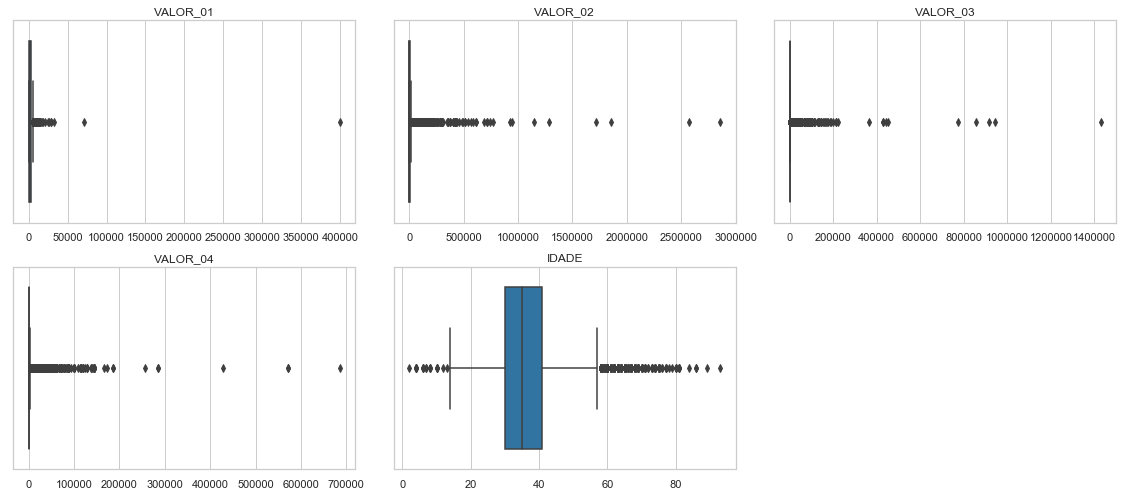

In [6]:
# Criando um canvas para os subplots
plt.figure(figsize=(16,7))

# Plotando recursivamente os boxplots
for i, col in enumerate(NumVars):
    plt.subplot(2,3,i+1)
    sns.boxplot(data=df,x=col)
    plt.xlabel('')
    plt.title(col)
    
plt.tight_layout()
plt.show()

Os dados são intensamente assimétricos. Alguns algoritmos de cluster são sensíveis aos outliers e podem distorcer os resultados.

Por fim, vamos olhar para as correlações entre as variáveis numéricas. 

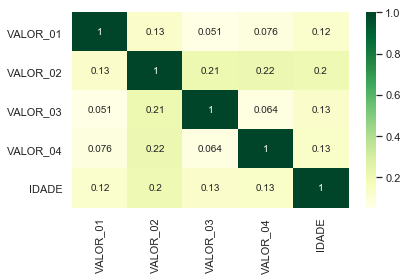

In [7]:
df_corr = df[NumVars].corr() # Matriz de correlação

# Construção do mapa de calor
sns.heatmap(df_corr, annot=True, cmap = "YlGn")
plt.tight_layout()
plt.show()

Um ponto positivo é que nenhuma das variáveis possuem alto coeficiente de correlação. A colinearidade não é um ponto vital na construção de clusters, mas a sua presença pode ocasionar uma oneração desnecessária ao algoritmo como para todo o processo em si. Quando possuimos um dataset sem colinearidade, podemos assumir que cada uma das variáveis contam histórias diferentes, ou seja, são capazes de explicar o dataset de diferentes formas.  

<a id='quali'></a>

## Variáveis categóricas

Nesta parte, entenderemos como se distribuem as variáveis qualitativas e as trataremos de forma que possam ser utilizadas dentro de algum algoritmo de construção de clusters.

Começamos pela profissão dos usuários. Por conta de um alto número de valores distintos, será necessário a construção de um agrupamento mais macro das profissões.

### Profissão

A variável Profissão possui 79 profissões distintas
Dentre elas, as mais frequentes são:


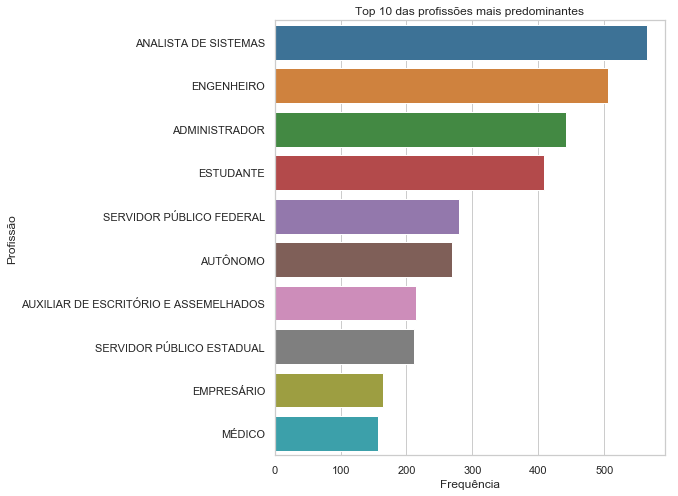

In [8]:
profi_count = df.PROFISSAO.value_counts() # Contagem das profissões
top10_profi = profi_count.head(10) # Somente as 10 primeiras

print("A variável Profissão possui",df.PROFISSAO.nunique(),
      "profissões distintas")
print("Dentre elas, as mais frequentes são:")

plt.figure(figsize=(7,8))
sns.barplot(x=top10_profi, y=top10_profi.index, saturation=0.6)
plt.xlabel("Frequência")
plt.ylabel("Profissão")
plt.title("Top 10 das profissões mais predominantes")
plt.show()

Aproximadamente $11\%$ dos usuários são Analistas de Sistemas e outros $10\%$ são engenheiros. 

Dado a volumetria de profissões distintas, é necessário criar agrupamentos mais consistentes e macros. Para isso, irei utilizar uma definição construída pelo Ministério do Trabalho que tem como objetivo a padronização em cenário nacional das profissões. Para maiores informações, recomenda-se a leitura do livro mais atualizado, disponibilizado neste [link](http://www.cofen.gov.br/wp-content/uploads/2015/12/CLASSIFICA%C3%87%C3%83O-BRASILEIRA-DE-OCUPA%C3%87%C3%95ES-MEC.pdf).

Os dados que contém as profissões padronizadas e seus respectivos códigos podem ser baixadas no link: [CBO](http://www.mtecbo.gov.br/cbosite/pages/downloads.jsf)

In [9]:
cbo_pth = "./CBO2002 - Ocupacao.csv"
ocup = pd.read_csv(cbo_pth, sep=";",encoding = "ISO-8859-1")
print("O dataset oficial das Classificação Brasileira de Ocupações possui",
     '{0:,}'.format(ocup.shape[0]), "profissões distintas.")
ocup.head()

O dataset oficial das Classificação Brasileira de Ocupações possui 2,626 profissões distintas.


,CODIGO,TITULO
0,10105,Oficial general da aeronáutica
1,10110,Oficial general do exército
2,10115,Oficial general da marinha
3,10205,Oficial da aeronáutica
4,10210,Oficial do exército


Cada uma das 2,626 profissões possui um código específico de 5 dígitos. Este código foi criado de forma que possamos identificar quais grupos (dentre os 4 níveis) a profissão pertence. 

O trecho abaixo, retirado do [portal do Ministério do Trabalho](http://www.mtecbo.gov.br/cbosite/pages/informacoesGerais.jsf) explica como funciona a estrutura do código:

![est_CBO](img/est_cbo.png)

O grupo mais macro do código é "Grande Grupo" e possui 10 classificações para todas as 2,626 profissões. Os grandes grupos são:

![CBO](img/CBO.png)

Para identificar onde serão classificados cada uma das profissões do nosso dataset, utilizei um algoritmo de similaridade de textos por meio de lógica fuzzy para encontrar as ocupações do CBO mais parecidas com as presentes no dataset e estipulei uma confiança de 90% de match para considerar um acerto. 

In [10]:
def MatchJob(Job, precision):
    """
    Encontra e retorna a ocupação mais similar de acordo com o agrupamento
    CBO2002.
    """
    match = process.extract(Job, ocup.TITULO, limit=1)
    if match[0][1] > precision:
        return match[0][0]
    else:
        return np.NaN

# Criando a lista de Matchs.
Prof_Padroes = pd.DataFrame({
    "PROFISSAO": list(set(df.PROFISSAO)),
    "OCUPACAO_CBO": [MatchJob(J, 90) for J in list(set(df.PROFISSAO))]
    })
Prof_Padroes.head()

,PROFISSAO,OCUPACAO_CBO
0,TRABALHADOR METALÚRGICO E SIDERÚRGICO,NaN
1,TÉCNICO DE MECÂNICA,NaN
2,PILOTO DE AERONAVES,Piloto de aeronaves
3,PROPRIETÁRIO DE ESTABELECIMENTO AGRÍCOLA,NaN
4,TÉCNICO DE LABORATÓRIO E RAIO X,NaN


Ao fim, poucas profissões deram um match confiável com as ocupações do CBO. Aquelas que não foi possível destinguir por meio do algoritmo serão analisadas manualmente dentro das opções dadas pela função criada. 

In [11]:
def FindJob(Job, l=3):
    """
    Função para encontrar as profissões registradas no CBO2002 que mais 
    se assimilam ao parâmetro de entrada;
    """
    print("Para a profissão",Job)
    res = process.extract(Job, ocup.TITULO, limit=l)
    
    for i, Match in enumerate(res):
        nm = Match[0]
        cnf = Match[1]
        cd = ocup[ocup.TITULO == Match[0]].iloc[0,0]
        
        print(i+1, "-"*90)
        print("\tMatch:", nm)
        print("\tConfiança:", cnf)
        print("\tCódigo:", cd)
    
    return
    
FindJob("Estatístico",5)

Para a profissão Estatístico
1 ------------------------------------------------------------------------------------------
	Match: Estatístico
	Confiança: 100
	Código: 211205
2 ------------------------------------------------------------------------------------------
	Match: Estatístico (estatística aplicada)
	Confiança: 90
	Código: 211210
3 ------------------------------------------------------------------------------------------
	Match: Estatístico teórico
	Confiança: 90
	Código: 211215
4 ------------------------------------------------------------------------------------------
	Match: Físico (estatística e matemática)
	Confiança: 81
	Código: 213125
5 ------------------------------------------------------------------------------------------
	Match: Professor de estatística (no ensino superior)
	Confiança: 81
	Código: 234115


Foi possível encontrar 5 grandes grupos (0, 1, 2, 3 e 7). Também, foi criado duas outras classificações: 
* Autônomos: Profissionais que não possuem uma ocupação formal, como por exemplo: donos de lojas, propriedades, etc.
* Outros: Ocupações não profissionais como estudantes e aposentados. 

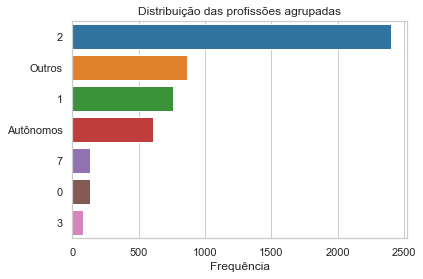

In [12]:
# Membros Das Forças Armadas, Policiais E Bombeiros Militares
GrandeGrupo0 = 'MILITAR EM GERAL;MILITAR REFORMADO'.split(';')

# Membros Superiores Do Poder Público, Dirigentes De Organizações De 
# Interesse Público E De Empresas, Gerentes
GrandeGrupo1 = 'SERVIDOR PÚBLICO FEDERAL;SERVIDOR PÚBLICO MUNICIPAL;\
SERVIDOR PÚBLICO ESTADUAL;RELAÇÕES PÚBLICAS;\
MEMBRO DO PODER JUDICIÁRIO: MINISTRO DE TRIB. SUP;\
BANCARIO E ECONOMIÁRIO;MEMBRO DO PODER EXECUTIVO: \
PRES.REPÚBLICA;DIRETOR DE EMPRESAS;GERENTE'.split(";")

# Profissionais Das Ciências E Das Artes
GrandeGrupo2 = "ENFERMEIRO E NUTRICIONISTA;\
PROFESSOR DE PRIMEIRO E SEGUNDO GRAUS;PUBLICITÁRIO;\
TÉCNICO DE CONTABILIDADE E DE ESTATÍSTICA;CONTADOR;\
FONOAUDIÓLOGO;JORNALISTA;ADVOGADO;VETERINÁRIO E ZOOTECNISTA;\
QUIMICO;SOCIÓLOGO;AGRONOMO;MÚSICO;GEÓLOGO;FÍSICO;PSICÓLOGO;\
ODONTÓLOGO E DENTISTA;FARMACÊUTICO;\
ENGENHEIRO;FISIOTERAPEUTA E TERAPEUTA OCUPACIONAL;\
ANALISTA DE SISTEMAS;ADMINISTRADOR;PILOTO DE AERONAVES;\
ROTEIRISTA / ESCRITORA;ECONOMISTA;DECORADOR;\
PROFESSOR DE ENSINO SUPERIOR;MÉDICO;ARQUITETO;\
BIÓLOGO E BIOMÉDICO;FONOAUDIÓLOGO".split(";")

# Técnicos De Nivel Médio
GrandeGrupo3 = "ATLETA PROFISSIONAL E TÉCNICO EM DESPORTOS;\
CORRETOR DE IMÓVEIS;TÉCNICO DE MECÂNICA;SECURITÁRIO;\
TÉCNICO DE QUÍMICA;AGENTE DE VIAGEM E GUIA DE TURISMO;\
TÉCNICO DE BIOLOGIA;MECÂNICO DE MANUT DE VEÍCULOS AUTOS E MÁQUINAS;\
MECANICO DE MANUTENÇÃO;TÉCNICO DE LABORATÓRIO E RAIO X;\
MODELO DE MODAS".split(";")

# Trabalhadores Da Produção De Bens E Serviços Industriais
GrandeGrupo7 = "ELETRICISTA E ASSEMELHADOS;\
MAQUINISTA E FOGUISTA DE EMBARCAÇ'ES;\
MOTORISTA DE VEICULOS DE TRANSPORTE DE CARGA;\
TÉCNICO DE ELETRICIDADE;\
TRABALHADOR DE CONSTRUÇÃO CIVIL;\
MOTORISTA DE VEÍCULOS DE TRANSPORTE DE PASSAGEIROS".split(";")

# Autônomos
GrandeGrupoAut = "PROPRIETÁRIO DE IMÓVEL (RECEBENDO REND DE ALUGUEL);\
PROPRIETÁRIO DE ESTABELECIMENTO DE PREST DE SERV;\
EMPRESÁRIO ART E PRODUTOR DE ESPETÁCULOS PÚBLICOS;EMPRESÁRIO;\
VENDEDOR DE COMÉRCIO VAREJISTA E ATACADISTA;AUTÔNOMO;\
PROPRIETÁRIO DE ESTABELECIMENTO AGRÍCOLA;\
PROPRIETÁRIO DE ESTABELECIMENTO INDUSTRIAL;\
PROPRIETARIO DE MICROEMPRESAS;\
PROPRIETÁRIO DE ESTABELECIMENTO COMERCIAL".split(";")

def Group_Jobs(Job):
    """
    Categorizar as Profissões do dataset
    """
    if Job.upper() in GrandeGrupo0:
        return '0'
    elif Job.upper() in GrandeGrupo1:
        return '1'
    elif Job.upper() in GrandeGrupo2:
        return '2'
    elif Job.upper() in GrandeGrupo3:
        return '3'
    elif Job.upper() in GrandeGrupo7:
        return '7'
    elif Job.upper() in GrandeGrupoAut:
        return 'Autônomos'
    else: 
        return "Outros"

# Constrói coluna com as profissões categorizadas
df['AGR_PROFISSAO'] = df.PROFISSAO.apply(Group_Jobs)

# Plot da distribuição das profissões agrupadas
agr_prof = df['AGR_PROFISSAO'].value_counts()
sns.barplot(x=agr_prof, y=agr_prof.index)
plt.xlabel('Frequência')
plt.title('Distribuição das profissões agrupadas')
plt.show()

Para não ter que rodar este processo toda vez, salvamos a base e também todas as associações realizadas pelo algoritmo.

Por último, recodificamos o Estado Civil dos usuários.

### Estado civil

Neste campo é possível identificar redundâncias desnecessárias para um processo de cluster. Logo, existe a oportunidade de consolidar grupos menores.

In [13]:
# Tabela de frequências da variável estado civil
EC_freq = pd.crosstab(index=df.ESTADO_CIVIL,
                      columns="count") 
EC_freq.columns.names = [''] # Retira nome padrão da tabela
EC_freq

,count
ESTADO_CIVIL,
CASADO(A) COM BRASILEIRO(A) NATO(A),1870
CASADO(A) COM BRASILEIRO(A) NATURALIZADO(A),13
CASADO(A) COM ESTRANGEIRO(A),20
DESQUITADO(A),19
DIVORCIADO(A),164
SOLTEIRO(A),2584
UNIAO ESTAVEL,267
VIUVO(A),35


Por exemplo, consideraremos um usuário como casado independente da naturalidade de seu cônjuge. E trataremos como iguais os usuários desquitados e divorciados. São distinções de origem legal que não são importantes para a aplicação do cluster.

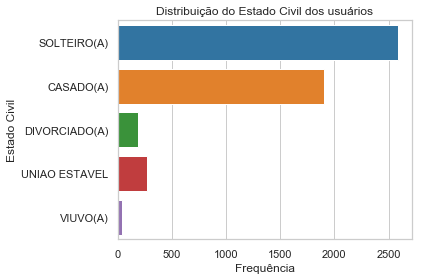

In [14]:
def Recode_EC(EC):
    """
    Recategorização do Estado Civil
    """
    if 'CASADO' in EC.upper():
        return 'CASADO(A)'
    elif 'DESQUITADO' in EC.upper():
        return 'DIVORCIADO(A)'
    else:
        return EC

# Construção da coluna agrupada de Estado civil
df['AGR_ESTADO_CIVIL'] = df.ESTADO_CIVIL.apply(Recode_EC)

sns.countplot(data=df, y='AGR_ESTADO_CIVIL')
plt.ylabel("Estado Civil")
plt.xlabel("Frequência")
plt.title('Distribuição do Estado Civil dos usuários')
plt.tight_layout()
plt.show()

Com isso, finalizamos os tratamentos das variáveis categóricas. 

<a id='kproto'></a>
## Cluster: K-Prototypes

A técnica adotada neste trabalho será o [K-Prototypes](https://pdfs.semanticscholar.org/d42b/b5ad2d03be6d8fefa63d25d02c0711d19728.pdf).
O K-Prototypes é um algoritmo de cluster altamente escalável e que possui um processo de clusterização semelhante ao do algoritmo K-Means, levando como diferencial a combinação com o algoritmo [K-Modes](http://www.irma-international.org/viewtitle/10828/) que nos permite trabalhar tanto com dados quantitativos como com os dados qualitativos.

O algoritmo K-Prototypes, para as variáveis quatitativas, utiliza a Distância Euclidiana como métrica de dissimilaridade entre os pontos e os centroides (média aritmética) dos clusters, da mesma forma que o K-Means. Enquanto para as variáveis qualitativas, a métrica utilizada é chamada de **Dissimilaridade de correspondência** (Tradução livre de: _Matching Dissimilarity_), a mesma utilizada no algoritmo K-Modes.

Na prática, redefinimos a função de distância para:

$d(X_i, Q_l) = \sum \limits ^{m_r}_{j=1} (x_{ij}^r - q_{lj}^r)^2 + \gamma_l \sum \limits ^{m_c}_{j=1} \delta(x_{ij}^c - q_{lj}^c)$

onde,
* $X_i$ é a $i$-ésimo linha dos dados
* $Q_l$ é o $l$-ésimo Cluster
* $m_r$ é o número de variáveis quantitativas
* $m_c$ é o número de variáveis qualitativas
* $\gamma_l$ é o de pesos das variáveis qualitativas no cluster $l$ 
* $\delta$ é a função de dissimilaridade para variáveis categóricas


A função de custo, métrica utilizada para o ajuste dos clusters, será dada pela soma de todas as distância dos pontos para seus respectivos clusters. 

O algoritmo implementado pelo _nicodv_ no [github](https://github.com/nicodv/kmodes/blob/master/kmodes/kprototypes.py), quando não provido de centroides, utiliza diversos centroides aleatórios. Como no K-means, o algoritmo K-Prototypes procura minimizar o custo total dos clusters que pode não ser um ponto de minimo global. Para previnir este problema, o algoritmo constrói os cluster para diferentes centróides aleatórios e decide por aquele que apresentar o menor custo. Este procedimento recebe o nome de **Processo de Realocação**

O custo computacional deste algoritmo é $O((t+1)kn)$, onde $n$ é o número de linhas, $k$ o número de clusters e $t$ o número de iterações do processo de realocação.

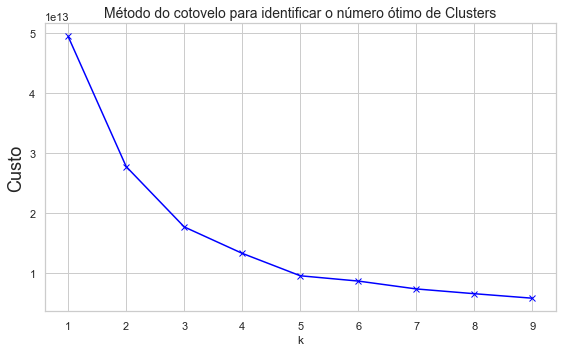

In [15]:
# Variáveis Categóricas
CatVars = 'AGR_PROFISSAO;GENERO;AGR_ESTADO_CIVIL;PERFIL'.split(';')
X = df.copy()[NumVars + CatVars]

cost = [] # Lista vazia para inserção de Custos

K = range(1,10) # Inicializa comprimento dos testes
for k in K:
    Kproto = KPrototypes(n_clusters=k, init='Huang', 
                         verbose=0, random_state=42, n_jobs=3)
    Kproto.fit(X,categorical=[5,6,7,8])
    cost.append(Kproto.cost_)

# Gráfico do cotovelo
plt.figure(figsize = (8,5))
plt.plot(K, cost, 'bx-')
plt.xlabel('k')
plt.ylabel('Custo', fontsize=18)
plt.title('Método do cotovelo para identificar o número ótimo de Clusters', fontsize=14)
plt.tight_layout()
plt.show()

Através de análise julgamental e visual, o ponto do cotovelo é quando o número de clusters é igual a 3. 

In [16]:
# Ajuste do K-Prototypes para 3 clusters
Kproto = KPrototypes(n_clusters=3, init='Huang', 
                         verbose=0, random_state=42, n_jobs=3)
Kproto.fit(X,categorical=[5,6,7,8])

# Criando coluna com a variável que discrimina os clusters
df['CLUSTER'] = Kproto.labels_

# Tabela de frequências dos clusters
cl_freq = pd.crosstab(index=df.CLUSTER,
                      columns="count") 
cl_freq.columns.names = [''] # Retira nome padrão da tabela
cl_freq

,count
CLUSTER,
0,4808
1,7
2,157


### Prós e Contras do algoritmo

O maior **ponto positivo** do algoritmo K-Prototype e o motivo por ter optado por ele é o fato da possibilidade de utilizar a maioria dos dados do dataset, permitindo a construção de clusteres melhores definidos.

O **lado negativo** é o fato de ele não ser robusto aos outliers presentes neste dataset, o que é na verdade, um ponto fraco importado do algoritmo K-Means.

### Resultados dos Clusters

Agora, devemos entender cada um dos clusters e descobrir qual seu perfil 

In [17]:
cls = df[NumVars + ['CLUSTER']] # Somente variáveis do cluster
cls.groupby('CLUSTER').mean().round(1)

,VALOR_01,VALOR_02,VALOR_03,VALOR_04,IDADE
CLUSTER,,,,,
0,1898.7,8329.9,2292.1,4108.6,36.4
1,9183.7,1767346.9,240538.4,43265.3,54.1
2,5502.0,256348.2,53556.1,31896.1,49.6


Temos então as seguintes interpretações:

* **Cluster 0:** São usuários mais jovens e com baixas quantias de valores, na maioria das vezes homens solteiros e trabalham em áreas de alta competência, como engenheiros, advogados, admistradores ou médicos. Também, muitos deles possuem o perfil A.


* **Cluster 1:** Estes usuários possuem os maiores valores. Casados, os usuários do cluster 1 possuem idades consideradas avançadas e sua grande maioria são aposentados de perfil B.


* **Cluster 2:** Os usuários do Cluster 2 possuem valores médios. Eles são casados e possuem profissões voltadas para as ciências e artes. São em geral homens maduros que possuem um perfil B. Usuários neste grupo provavelmente migrarão para o Cluster 1 no futuro.

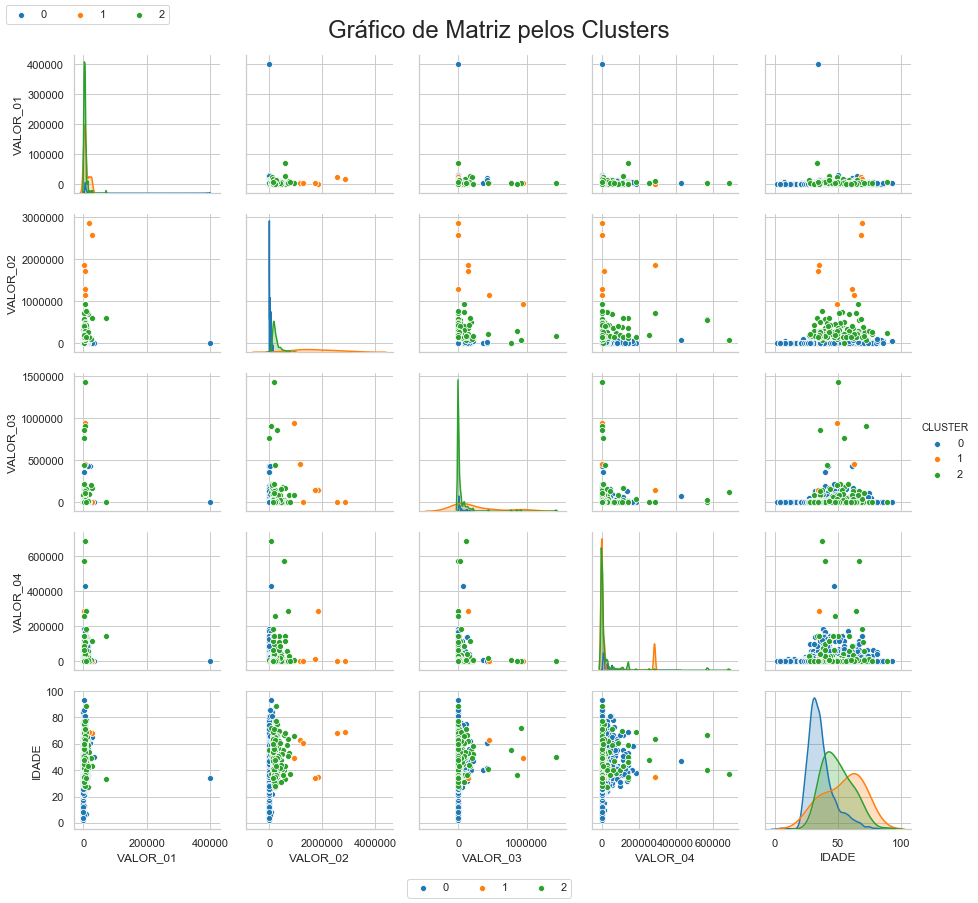

In [18]:
g = sns.pairplot(data=df, hue='CLUSTER', vars = NumVars, diag_kind='kde')
handles = g._legend_data.values()
labels = g._legend_data.keys()
g.fig.legend(handles=handles, labels=labels, loc='upper left', ncol=3)
g.fig.legend(handles=handles, labels=labels, loc='lower center', ncol=3)
g.fig.subplots_adjust(top=0.94, bottom=0.08)
plt.suptitle("Gráfico de Matriz pelos Clusters", fontsize = 24)
plt.show()

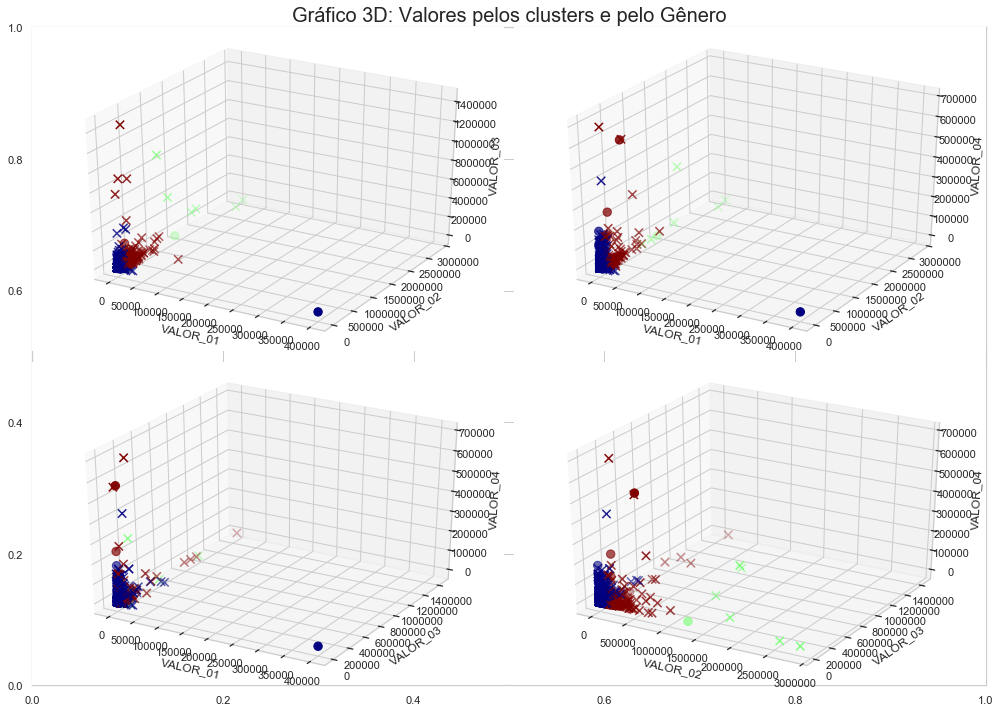

In [19]:
cmb = list(map(list,combinations(range(4,8),3)))
fig = plt.figure(figsize=(14,10))
plt.title("Gráfico 3D: Valores pelos clusters e pelo Gênero", fontsize=20)

w = X.GENERO == "F"
m = X.GENERO == "M"

#===============
#  First subplot
#===============
# set up the axes for the first plot
ax = fig.add_subplot(2, 2, 1, projection='3d')

# plot a 3D surface like in the example mplot3d/surface3d_demo

ax.scatter(df[w].iloc[:,cmb[0][0]],
           df[w].iloc[:,cmb[0][1]],
           df[w].iloc[:,cmb[0][2]], 
           c=df['CLUSTER'][w],
           marker='o',
           cmap='jet',
           s=70)

ax.scatter(df[m].iloc[:,cmb[0][0]],
           df[m].iloc[:,cmb[0][1]],
           df[m].iloc[:,cmb[0][2]], 
           c=df['CLUSTER'][m],
           marker='x',
           cmap='jet',
           s=70)

cl = df.iloc[:,cmb[0]].columns
ax.set_xlabel(cl[0])
ax.set_ylabel(cl[1])
ax.set_zlabel(cl[2])

#===============
# Second subplot
#===============
# set up the axes for the second plot
ax = fig.add_subplot(2, 2, 2, projection='3d')

# plot a 3D wireframe like in the example mplot3d/wire3d_demo

ax.scatter(df[w].iloc[:,cmb[1][0]],
           df[w].iloc[:,cmb[1][1]],
           df[w].iloc[:,cmb[1][2]], 
           c=df['CLUSTER'][w],
           marker='o',
           cmap='jet',
           s=70)

ax.scatter(df[m].iloc[:,cmb[1][0]],
           df[m].iloc[:,cmb[1][1]],
           df[m].iloc[:,cmb[1][2]], 
           c=df['CLUSTER'][m],
           marker='x',
           cmap='jet',
           s=70)

cl = df.iloc[:,cmb[1]].columns
ax.set_xlabel(cl[0])
ax.set_ylabel(cl[1])
ax.set_zlabel(cl[2])


#===============
# Third subplot
#===============
# set up the axes for the second plot
ax = fig.add_subplot(2, 2, 3, projection='3d')

# plot a 3D wireframe like in the example mplot3d/wire3d_demo

ax.scatter(df[w].iloc[:,cmb[2][0]],
           df[w].iloc[:,cmb[2][1]],
           df[w].iloc[:,cmb[2][2]], 
           c=df['CLUSTER'][w],
           marker='o',
           cmap='jet',
           s=70)

ax.scatter(df[m].iloc[:,cmb[2][0]],
           df[m].iloc[:,cmb[2][1]],
           df[m].iloc[:,cmb[2][2]], 
           c=df['CLUSTER'][m],
           marker='x',
           cmap='jet',
           s=70)
cl = df.iloc[:,cmb[2]].columns
ax.set_xlabel(cl[0])
ax.set_ylabel(cl[1])
ax.set_zlabel(cl[2])

#===============
# Fourth subplot
#===============
# set up the axes for the second plot
ax = fig.add_subplot(2, 2, 4, projection='3d')

# plot a 3D wireframe like in the example mplot3d/wire3d_demo

ax.scatter(df[w].iloc[:,cmb[3][0]],
           df[w].iloc[:,cmb[3][1]],
           df[w].iloc[:,cmb[3][2]], 
           c=df['CLUSTER'][w],
           marker='o',
           cmap='jet',
           s=70)

ax.scatter(df[m].iloc[:,cmb[3][0]],
           df[m].iloc[:,cmb[3][1]],
           df[m].iloc[:,cmb[3][2]], 
           c=df['CLUSTER'][m],
           marker='x',
           cmap='jet',
           s=70)

cl = df.iloc[:,cmb[3]].columns
ax.set_xlabel(cl[0])
ax.set_ylabel(cl[1])
ax.set_zlabel(cl[2])

plt.tight_layout()
plt.show()

<a id='futscr'></a>
## Futuras Escoragens

Na raiz do projeto, existe um arquivo de texto chamado **_requirements.txt_**. Nele estão dispostas todas as bibliotecas que foram utilizadas e suas respectivas versões. 

Para instalá-los, basta executar o seguinte comando no terminal:

```
pip install -r requirements.txt
```
Abaixo, utilizo a biblioteca "pickle" para salvar o ajuste do cluster.

In [20]:
import pickle
filename = 'kproto_cluster.sav' # Nome do arquivo
pickle.dump(Kproto, open(filename, 'wb')) # Exportar arquivo

Também na pasta raiz, foi criado um arquivo chamado **kproto_cluster.sav**. Em outros códigos, o ajuste dos clusters pode ser importados e utilizados como no exemplo abaixo:

```
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(X)
```

<a id='consfin'></a>
## Considerações Finais

O K-Prototypes ainda é uma técnica pouco desenvolvida, apesar de seu artigo ter sido publicado por Huang em 1997. Com a evolução de tantos algoritmos de clusterização, acredito ser viável a substituição do K-Means dentro do K-Prototypes.

Foi pensado outras soluções para este trabalho, como por exemplo construir clusters separados para variáveis numéricas com o K-medians e para as categóricas com o K-Modes, e então, interagi-las para criar novos clusters. Porém, limitado ao tempo e também em escorando na simplicidade, optei pela técnica mais direta que dispunha.

Acredito que seria viável também, em um momento futuro, a aplicação da dissimilaridade de Gower para atacar este problema. Porém, esta técnica até o momento só possui implementação em R e seria um tanto custoso e insensato a construção do algoritmo neste trabalho.

No mais, gostaria de expressar o meu contentamento com este case em que após muita dedicação, fui capaz de aprender, crescer e caminhar cada vez mais em direção a minha ambição: Me tornar um excelente cientista de dados.